## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 9: Overfitting and Underfitting

### Notebook 3: Line Fitting

This notebook is in a pretty rough state. I rebuilt these figures
during one of the last edit passes through the manuscript, and I had
to do it quickly. Things are a bit more thrown-together than usual.
I apologize, but I've added some comments and I hope you'll be able
to follow the flow. 

Note that the saved files often have names like "Fig3.png" - these
were for keeping track as I was working, and don't correspond to the
final figure numbers in the book.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import seaborn as sns ; sns.set()

Mesh_res = 500

In [2]:
WriteFiles = False

In [3]:
# A convenience to make a square plot, with or without ticks

def make_plot_axes_ticks_square_grid(show_axes=True, do_ticks=True, 
                                  limited_ticks=True, set_limits=True, 
                                  set_square=True, extent=3):
    ax = plt.gca()
    if do_ticks and limited_ticks:
        extent_floor = math.floor(extent)
        tick_locations = np.linspace(-extent_floor, extent_floor, 1+(2*extent_floor))
        plt.xticks(tick_locations, tick_locations)
        plt.yticks(tick_locations, tick_locations)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)
    if not do_ticks:
        ax.set_xticks([]) 
        ax.set_yticks([]) 
    if set_limits:
        plt.xlim(-extent,extent)
        plt.ylim(-extent,extent)
    if set_square:
        ax.set_aspect('equal')

In [4]:
# Compute a falloff "distance" between this point and line

def distance_point_line(px, py, m, b, eradius=20):
    distance = (m * px) - py + b;
    exp_distance = math.exp(eradius*-(distance**2))
    return exp_distance

In [5]:
# Utility proc to clip a line to a symmetrical box

def get_line_ends(m, b, x_range, y_range):
    x0 = -x_range
    x1 =  x_range
    y0 = (m * x0) + b
    y1 = (m * x1) + b

    x0, y0, x1, y1 = clip_segment_to_box(m, b, x0, y0, x1, y1, x_range, y_range)
        
    return([x0, y0, x1, y1])

In [6]:
# Clip a line segment to a symmetrical box.
# This is something that matplotlib should do perfectly well all by
# itself, but I was getting occasional errors with lines extending
# outside the box, so I wrote my own. You can absolutely do this in
# a much tighter and simpler way, but I needed to write something
# quickly that I knew would work, so I just chugged through the cases.
# This could surely be turned into a just a few lines of elegant code!

def clip_segment_to_box(m, b, x0, y0, x1, y1, x_range, y_range):
    if abs(m) < 0.00001:
        x0 = max(x0, -x_range)
        x0 = min(x0, x_range)
        x1 = max(x1, -x_range)
        x1 = min(x1, x_range)
        return [x0, y0, x1, y1]
    
    topx = (y_range - b)/m
    topy = y_range
    bottomx = (-y_range - b)/m
    bottomy = -y_range
    leftx = -x_range
    lefty = (m * -x_range) + b
    rightx = x_range
    righty = (m * x_range) + b
    
    # verbose but easy to understand. Choose the side that doesn't clip
    if y0 > y_range:
        x0 = topx
        y0 = topy
    elif y0 < -y_range:
        x0 = bottomx
        y0 = bottomy
    if y1 > y_range:
        x1 = topx
        y1 = topy
    elif y1 < -y_range:
        x1 = bottomx
        y1 = bottomy  
        
    if x0 > x_range:
        x0 = rightx
        y0 = righty
    elif x0 < -x_range:
        x0 = leftx
        y0 = lefty
    if x1 > x_range:
        x1 = rightx
        y1 = rightx
    elif x1 < -x_range:
        x1 = leftx
        x1 = lefty           

    return [x0, y0, x1, y1]

In [7]:
# Draw these lines and their corresponding slope-intercept points

def make_point_line_pair_from_cartesian_lines(lines, filename=None):
    x_range = y_range = 3
    plt.figure(figsize=(10,18))
    plt.subplot(1,2,1)
    for line in lines:
        m, b, clr = line
        x0, y0, x1, y1 = get_line_ends(m, b, x_range, y_range)
        plt.plot([x0, x1], [y0, y1], lw=2, c=clr)
    make_plot_axes_ticks_square_grid()
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.subplot(1,2,2)
    for line in lines:
        m, b, clr = line
        plt.scatter([m],[b], color=clr, s=85)
    plt.xlabel('Slope', fontsize=14)
    plt.ylabel('Y intercept', fontsize=14)
    make_plot_axes_ticks_square_grid(show_axes=False)
    plt.tight_layout()
    if (filename is not None) and WriteFiles:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

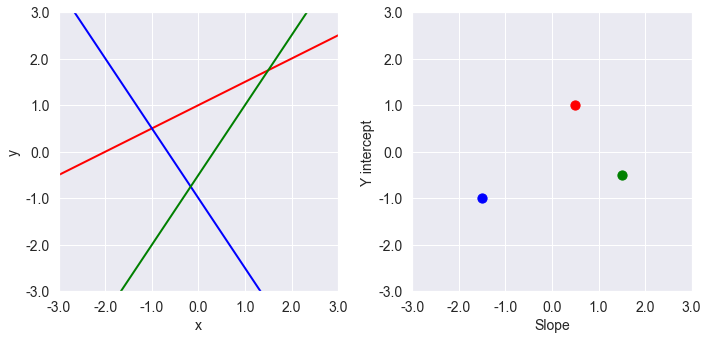

In [8]:
make_point_line_pair_from_cartesian_lines([[.5, 1, 'red'], [-1.5, -1, 'blue'], [1.5, -.5, 'green']], 
                                          filename='Fig1.png')

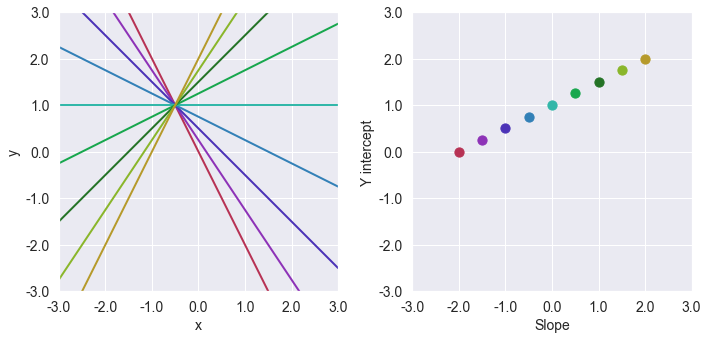

In [9]:
clrs = ['#B73254', '#8D32B7', '#4B32B7', '#3280B7', '#32B7A9', '#18A74E', '#247326', '#8AB62B', '#B69A2B']
ms = np.linspace(-2, 2, 9)
bs = np.linspace(0, 2, 9)
arglist = []
for i in range(len(ms)):
    arglist.append([ms[i], bs[i], clrs[i]])
make_point_line_pair_from_cartesian_lines(arglist, filename='Fig2.png')

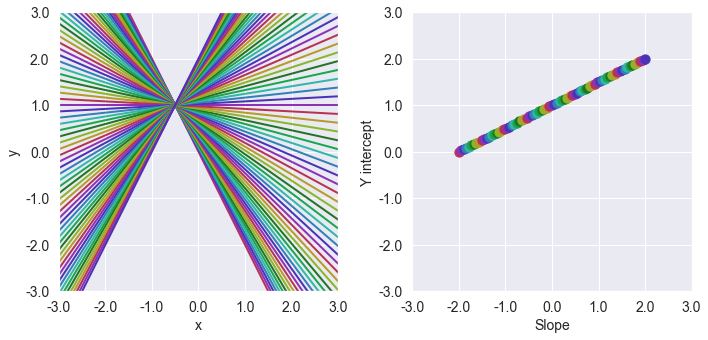

In [10]:
clrs = ['#B73254', '#8D32B7', '#4B32B7', '#3280B7', '#32B7A9', '#18A74E', '#247326', '#8AB62B', '#B69A2B']
ms = np.linspace(-2, 2, 75)
bs = np.linspace(0, 2, 75)
arglist = []
for i in range(len(ms)):
    arglist.append([ms[i], bs[i], clrs[i%len(clrs)]])
make_point_line_pair_from_cartesian_lines(arglist, filename='Fig3.png')

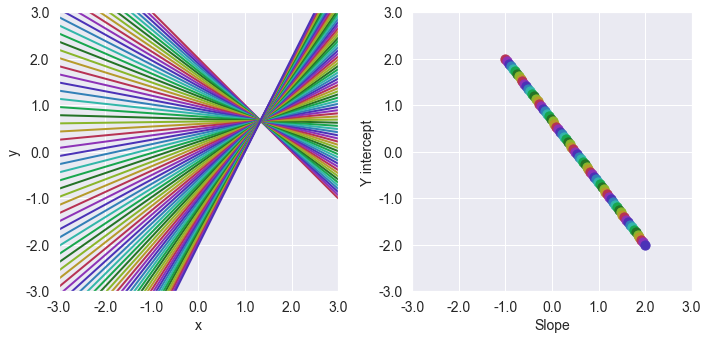

In [11]:
clrs = ['#B73254', '#8D32B7', '#4B32B7', '#3280B7', '#32B7A9', '#18A74E', '#247326', '#8AB62B', '#B69A2B']
ms = np.linspace(-1, 2, 75)
bs = np.linspace(2, -2, 75)
arglist = []
for i in range(len(ms)):
    arglist.append([ms[i], bs[i], clrs[i%len(clrs)]])
make_point_line_pair_from_cartesian_lines(arglist, filename='Fig4.png')

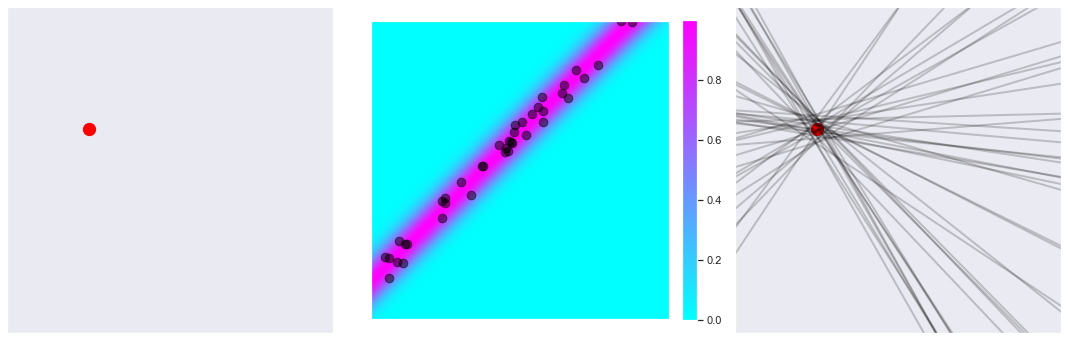

In [12]:
# Given a point, find how closely each line in slope-intercept space
# comes to that point. The closer it comes, the more probable it is 
# as a candidate line that passes through that point.

def make_line_probabilities_from_point(px, py, colorbar=True, cmap='cool', ticks=True, filename=None):
    clrs = ['#B73254', '#8D32B7', '#4B32B7', '#3280B7', '#32B7A9', '#18A74E', '#247326', '#8AB62B', '#B69A2B']

    plt.figure(figsize=(15,28))
    plt.subplot(1,3,1)
    
    plt.scatter([px], [py], color='red', s=150)
    make_plot_axes_ticks_square_grid(do_ticks=False, show_axes=False, extent=2)
    
    
    plt.subplot(1,3,2)
    x = np.linspace(-2, 2, Mesh_res)
    y = np.linspace(-2, 2, Mesh_res)
    X, Y = np.meshgrid(x,y)
    Z = np.zeros((Mesh_res, Mesh_res))
    for i in range(Mesh_res):
        for j in range(Mesh_res):
            Z[i,j] = distance_point_line(px, py, X[i,j], Y[i,j], 10)  
    ax = plt.gca()
    ax.set_aspect('equal')
    if ticks:
        plt.xticks([-2, -1, 0, 1, 2], fontsize=14)
        plt.yticks([-2, -1, 0, 1, 2], fontsize=14)
    else:
        plt.xticks([])
        plt.yticks([])
        
    plt.pcolor(x, y, Z, cmap=cmap, shading='auto')
    plt.colorbar(fraction=0.046, pad=0.04)
    #if colorbar:
        #plt.colorbar(fraction=0.046, pad=0.04)
        
    num_lines = 40
    ms = []
    bs = []
    threshold = 0.7
    for i in range(num_lines):
        found_one = False
        num_tries = 300
        try_number = 0
        while (try_number < num_tries) and (not found_one):
            xindex = int(np.random.uniform(0, Mesh_res))
            yindex = int(np.random.uniform(0, Mesh_res))
            if Z[yindex, xindex] > threshold:
                this_m = (4 * (xindex/Mesh_res)) - 2
                this_b = (4 * (yindex/Mesh_res)) - 2
                ms.append(this_m)
                bs.append(this_b)
                found_one = True
            try_number += 1
    for i in range(len(ms)):
        plt.scatter([ms[i]], [bs[i]], color='black', s=75, alpha=.5)
    make_plot_axes_ticks_square_grid(do_ticks=False, extent=2)


        
    plt.subplot(1,3,3)
    plt.scatter([px], [py], color='red', s=150)
    for i in range(len(ms)):
        x0, y0, x1, y1 = get_line_ends(ms[i], bs[i], 2, 2)
        plt.plot([x0, x1], [y0, y1], lw=2, c='black', alpha=0.2)
    make_plot_axes_ticks_square_grid(do_ticks=False, extent=2)
        
    plt.tight_layout()
    if (filename is not None) and WriteFiles:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
make_line_probabilities_from_point(-1, .5, filename='Fig5.png')

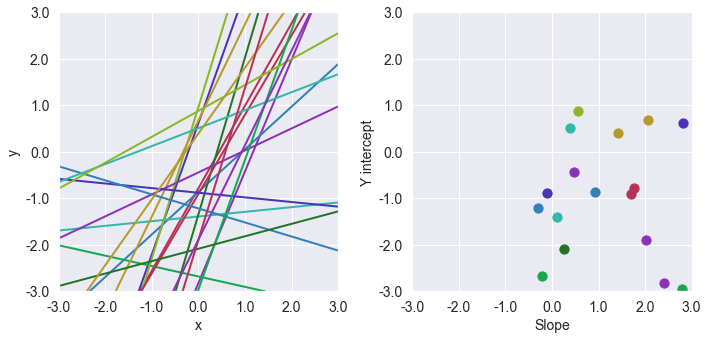

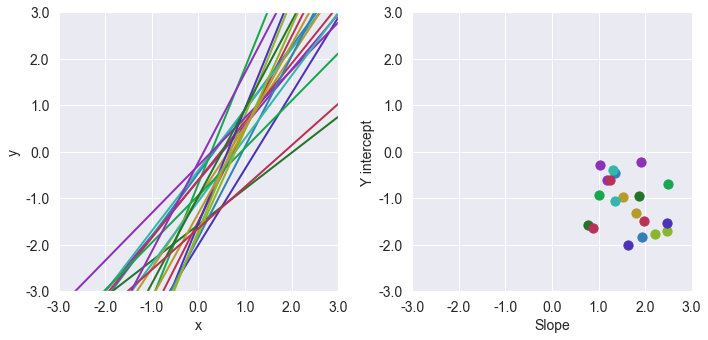

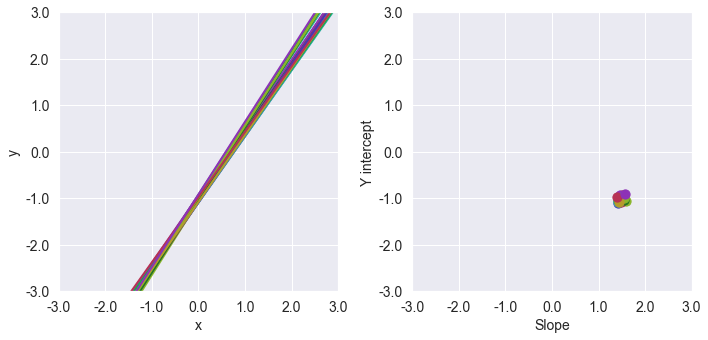

In [13]:
# Show some clustered points and corresponding lines

clrs = ['#B73254', '#8D32B7', '#4B32B7', '#3280B7', '#32B7A9', '#18A74E', '#247326', '#8AB62B', '#B69A2B']
numpts = 20
center_m = 1.5
center_b = -1
radii = [2, 1.0, 0.1]
filenames = ['Fig6.png', 'Fig7.png', 'Fig8.png']
for fig_number in range(len(radii)):
    radius = radii[fig_number]
    ms = []
    bs = []
    for i in range(numpts):
        ms.append(center_m + np.random.uniform(-radius, radius))
        bs.append(center_b + np.random.uniform(-radius, radius))
    arglist = []
    for i in range(len(ms)):
        arglist.append([ms[i], bs[i], clrs[i%len(clrs)]])
    make_point_line_pair_from_cartesian_lines(arglist, filename=filenames[fig_number])

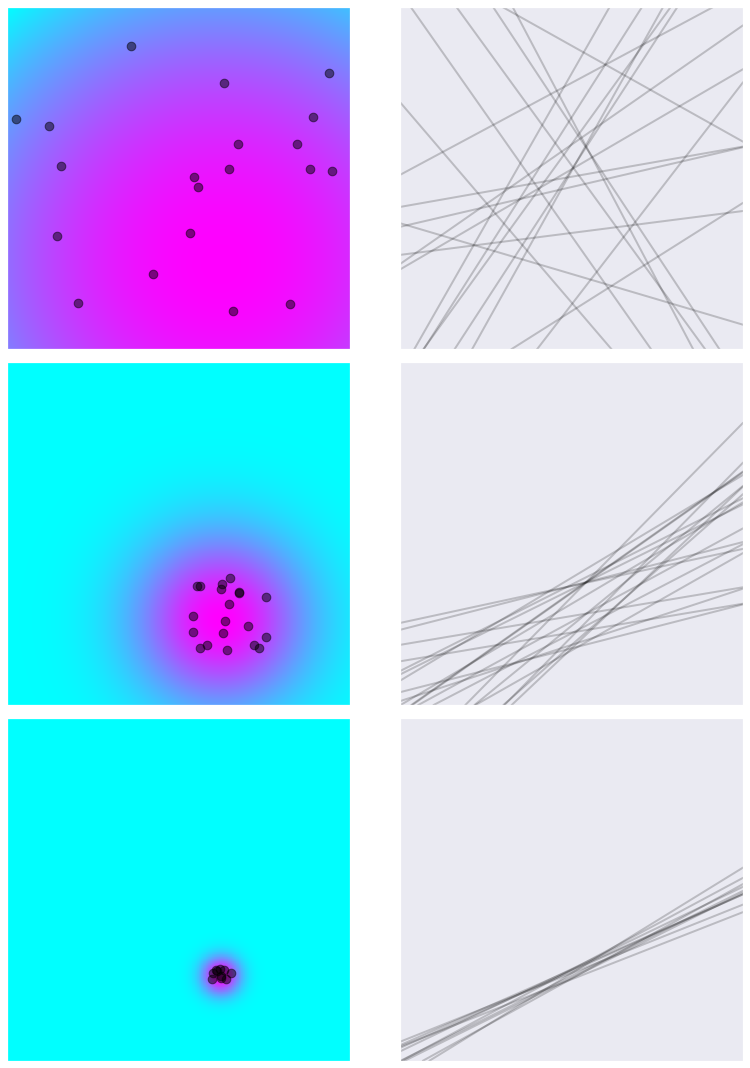

In [14]:
# For a few different priors (that is, probabilities in slope-intercept
# space), generate some lines by choosing from that prior and draw them.

num_lines = 20

clrs = ['#B73254', '#8D32B7', '#4B32B7', '#3280B7', '#32B7A9', '#18A74E', '#247326', '#8AB62B', '#B69A2B']
numpts = 20
center_m = 0.5
center_b = -1
radii = [2, 0.5, 0.1]
spreads = [.01, 1, 20]
x_range = y_range = 2

plt.figure(figsize=(12,15))  # width, height

for row in range(len(radii)):
    radius = radii[row]
    spread = spreads[row]
    
    plt.subplot(3, 2, 1+(2*row))
    
    x = np.linspace(-2, 2, Mesh_res)
    y = np.linspace(-2, 2, Mesh_res)
    X, Y = np.meshgrid(x,y)
    Z = np.zeros((Mesh_res, Mesh_res))
    for i in range(Mesh_res):
        for j in range(Mesh_res):
            dx = X[i, j] - center_m
            dy = Y[i, j] - center_b
            dist = math.sqrt((dx*dx)+(dy*dy))
            zdist = math.exp(-spread*(dist**2))
            Z[i,j] = zdist
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.pcolor(x, y, Z, cmap='cool', shading='auto')
           
    ms = []
    bs = []
    threshold = 0.7
    for i in range(num_lines):
        found_one = False
        num_tries = 300
        try_number = 0
        while (try_number < num_tries) and (not found_one):
            xindex = int(np.random.uniform(0, Mesh_res))
            yindex = int(np.random.uniform(0, Mesh_res))
            if Z[yindex, xindex] > threshold:
                this_m = (4 * (xindex/Mesh_res)) - 2
                this_b = (4 * (yindex/Mesh_res)) - 2
                ms.append(this_m)
                bs.append(this_b)
                found_one = True
            try_number += 1
    for i in range(len(ms)):
        plt.scatter([ms[i]], [bs[i]], color='black', s=75, alpha=.5)

    make_plot_axes_ticks_square_grid(do_ticks=False, extent=2)

    plt.subplot(3, 2, 2+(2*row))
    for i in range(len(ms)):
        x0, y0, x1, y1 = get_line_ends(ms[i], bs[i], x_range, y_range)
        plt.plot([x0, x1], [y0, y1], lw=2, c='black', alpha=0.2)
    make_plot_axes_ticks_square_grid(do_ticks=False, extent=2)
    
plt.tight_layout()
if WriteFiles:
    plt.savefig('Fig9.png', dpi=300, bbox_inches='tight')

plt.show()

The following functions make up the bits and pieces for the figure
that shows line fitting using repeated applications of Bayes' Rule.

In [15]:
def make_gaussian_prior(spread):
    x_range = np.linspace(-1, 1, Mesh_res)
    y_range = np.linspace(-1, 1, Mesh_res)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((Mesh_res, Mesh_res))
    for i in range(Mesh_res):
        for j in range(Mesh_res):
            dist = math.sqrt((X[i,j]*X[i,j])+(Y[i,j]*Y[i,j]))
            Z[i,j] = math.exp(spread*(dist**2))
    return Z

def make_base_curve(num_pts, noise_scale):
    base_curve = [2*(-.6+(.1 * ((x*10) + (2 * math.sin(1.5*x*10))))) for x in np.linspace(0, 1, num_pts)]
    noisy_curve = [cp + (np.random.randn() * noise_scale) for cp in base_curve]
    return (np.array(base_curve), np.array(noisy_curve))

def show_noisy_curve(color='#bbbbbb', zorder=10):
    xvals = np.linspace(-2, 2, Num_base_points)
    plt.plot(xvals, Noisy_curve, color=color, zorder=zorder)
    make_plot_axes_ticks_square_grid(do_ticks=False)

In [16]:
def show_noisy_curve_and_scatter(scatter_points):
    clrs = ['#D69D4A', '#C254CF', '#58AB45', '#8163D9', '#4DB3BD']
    show_noisy_curve()
    for sp_num in range(len(scatter_points)):
        color = '#888888'
        if sp_num == len(scatter_points)-1:
            color = 'red'
        sp = scatter_points[sp_num]
        plt.scatter(sp[0], sp[1], color=color, s=[170], zorder=20)

In [17]:
def draw_lines_from_prior(prior, num_demo_lines):
    ms = []
    bs = []
    x_range = y_range = 2
    prior_wid, prior_hgt = prior.shape
    threshold = 0.7 * np.max(prior)
    for i in range(num_demo_lines):
        found_one = False
        num_tries = 5000
        try_number = 0
        while (try_number < num_tries) and (not found_one):
            xindex = int(np.random.uniform(0, prior_wid))
            yindex = int(np.random.uniform(0, prior_hgt))
            if prior[yindex, xindex] > threshold:
                this_m = (4 * (xindex/prior_wid)) - 2
                this_b = (4 * (yindex/prior_hgt)) - 2
                ms.append(this_m)
                bs.append(this_b)
                found_one = True
            try_number += 1
            
    if len(ms) < num_demo_lines:
        print('draw_lines_from_prior: wanted ',num_demo_lines,' lines but found only ',len(ms))
            
    for i in range(len(ms)):
        x0, y0, x1, y1 = get_line_ends(ms[i], bs[i], x_range, y_range)
        plt.plot([x0, x1], [y0, y1], lw=2, c='black', alpha=0.2)

In [18]:
def show_dot_likelihood(px, py):
    
    x = np.linspace(-2, 2, Mesh_res)
    y = np.linspace(-2, 2, Mesh_res)
    X, Y = np.meshgrid(x,y)
    Z = np.zeros((Mesh_res, Mesh_res))
    for i in range(Mesh_res):
        for j in range(Mesh_res):
            Z[i,j] = distance_point_line(px, py, X[i,j], Y[i,j], 10)  
    plt.pcolor(x, y, Z, cmap='cool', shading='auto')

    return Z

In [19]:
def multiply_grids(grid1, grid2):
    grid3 = np.zeros(grid1.shape)
    for i in range(grid1.shape[0]):
        for j in range(grid1.shape[1]):
            grid3[i][j] = grid1[i][j] * grid2[i][j]
    # normalize
    return grid3

In [20]:
def plot_grid(grid):
    x_range = np.linspace(-2, 2, Mesh_res)
    y_range = np.linspace(-2, 2, Mesh_res)
    plt.pcolor(x_range, y_range, grid, cmap=Cmap, shading='auto')

In [21]:
Num_base_points = 500
Noise_scale = .05
Cmap = 'cool'

(Base_curve, Noisy_curve) = make_base_curve(Num_base_points, Noise_scale)


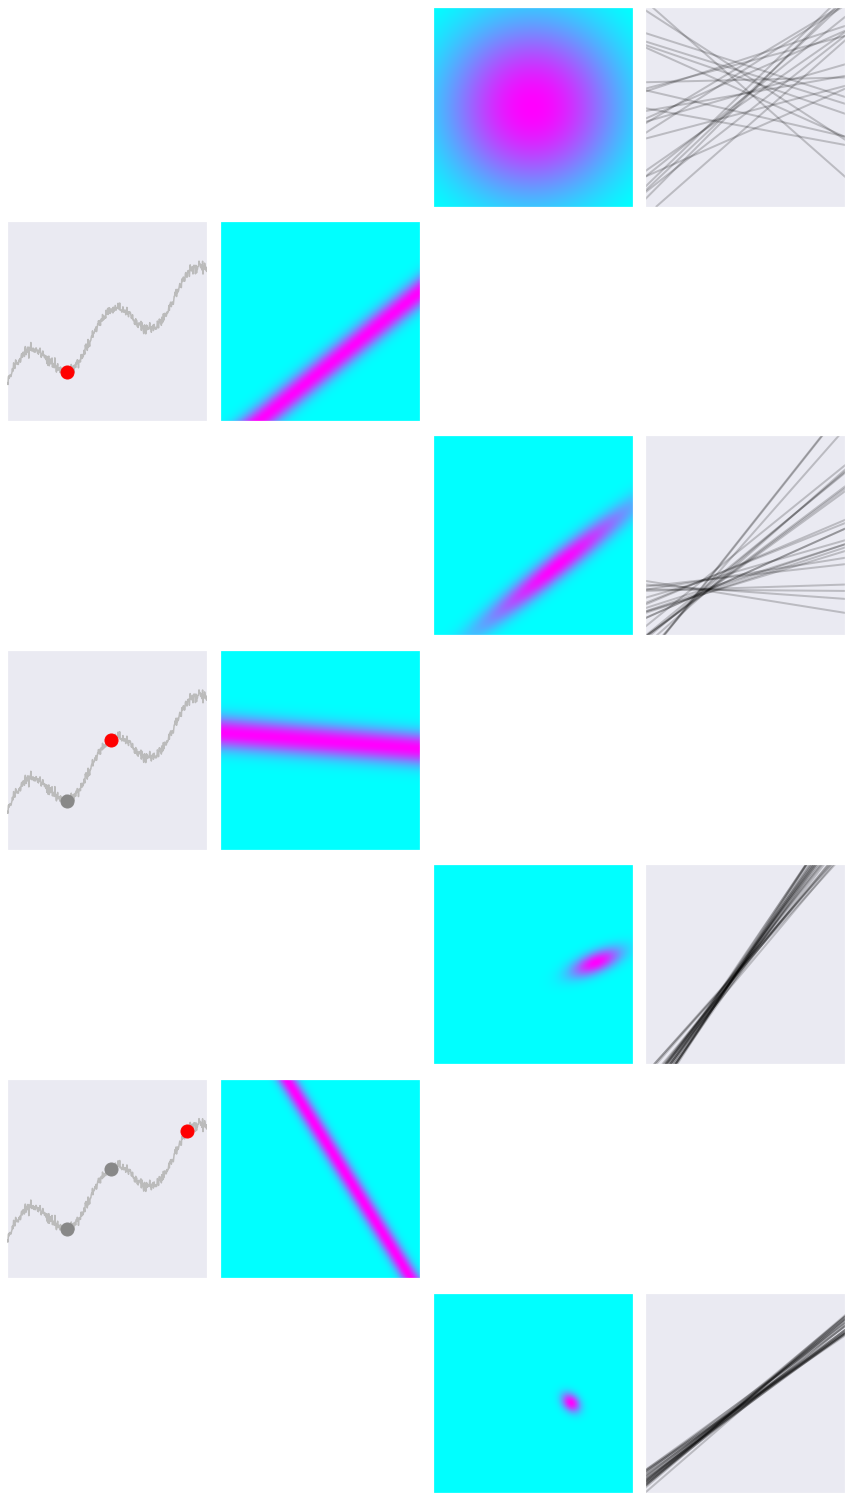

In [22]:
def make_bayes_fit_demo():

    num_demo_lines = 25
    fit_points = []
    np.random.seed(16)
    Cmap = 'cool'
    dotsize = 85


    # row 1
    plt.figure(figsize=(12,24))
    plt.subplot(8,4,3)
    prior = make_gaussian_prior(-1.2)

    # random prior
    # prior = np.random.uniform(.95, 1, size=(Mesh_res, Mesh_res))

    #plt.pcolor(prior, cmap=Cmap)    
    plot_grid(prior)
    make_plot_axes_ticks_square_grid(show_axes=False, do_ticks=False, limited_ticks=False, set_limits=False)

    plt.subplot(8,4,4)
    draw_lines_from_prior(prior, num_demo_lines)
    make_plot_axes_ticks_square_grid(show_axes=False, do_ticks=False, limited_ticks=False, set_limits=False)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    ax = plt.gca()
    ax.set_aspect('equal')

    # row 2
    fit_index = 150
    fit_points.append([(((fit_index/Num_base_points)*2)-1)*2, Noisy_curve[fit_index]])
    
    plt.subplot(8,4,5)
    show_noisy_curve_and_scatter(fit_points)
    make_plot_axes_ticks_square_grid(do_ticks=False, limited_ticks=False, extent=2)

    plt.subplot(8,4,6)
    likelihood = show_dot_likelihood(fit_points[-1][0], fit_points[-1][1])
    make_plot_axes_ticks_square_grid(show_axes=False, do_ticks=False, limited_ticks=False, extent=2)

    # row 3
    posterior = multiply_grids(likelihood, prior)    
    prior = np.copy(posterior)

    plt.subplot(8,4,11)
    plot_grid(posterior)
    make_plot_axes_ticks_square_grid(show_axes=False, do_ticks=False, limited_ticks=False, set_limits=False)
    
    plt.subplot(8,4,12)
    draw_lines_from_prior(prior, num_demo_lines)
    make_plot_axes_ticks_square_grid(show_axes=False, do_ticks=False, limited_ticks=False, set_limits=False)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    ax = plt.gca()
    ax.set_aspect('equal')
    

   # row 4
    fit_index = 260
    fit_points.append([(((fit_index/Num_base_points)*2)-1)*2, Noisy_curve[fit_index]])
    
    plt.subplot(8,4,13)
    show_noisy_curve_and_scatter(fit_points)
    make_plot_axes_ticks_square_grid(do_ticks=False, limited_ticks=False, extent=2)
    
    plt.subplot(8,4,14)
    likelihood = show_dot_likelihood(fit_points[-1][0], fit_points[-1][1])
    make_plot_axes_ticks_square_grid(show_axes=False, do_ticks=False, limited_ticks=False, extent=2)
    
    # row 5
    posterior = multiply_grids(likelihood, prior)    
    prior = np.copy(posterior)
    
    plt.subplot(8,4,19)
    plot_grid(prior)
    make_plot_axes_ticks_square_grid(show_axes=False, do_ticks=False, limited_ticks=False, extent=2)
    
    plt.subplot(8,4,20)
    draw_lines_from_prior(prior, num_demo_lines)
    make_plot_axes_ticks_square_grid(show_axes=False, do_ticks=False, limited_ticks=False, set_limits=False)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    ax = plt.gca()
    ax.set_aspect('equal')
    
        # row 6
    fit_index = 450
    fit_points.append([(((fit_index/Num_base_points)*2)-1)*2, Noisy_curve[fit_index]])
    
    plt.subplot(8,4,21)
    show_noisy_curve_and_scatter(fit_points)
    make_plot_axes_ticks_square_grid(do_ticks=False, limited_ticks=False, extent=2)
    
    plt.subplot(8,4,22)
    likelihood = show_dot_likelihood(fit_points[-1][0], fit_points[-1][1])
    make_plot_axes_ticks_square_grid(show_axes=False, do_ticks=False, limited_ticks=False, extent=2)
    
    # row 7
    posterior = multiply_grids(likelihood, prior)
    prior = np.copy(posterior)
    
    plt.subplot(8,4,27)
    plot_grid(prior)
    make_plot_axes_ticks_square_grid(show_axes=False, do_ticks=False, limited_ticks=False, extent=2)
    
    plt.subplot(8,4,28)
    draw_lines_from_prior(prior, num_demo_lines)
    make_plot_axes_ticks_square_grid(show_axes=False, do_ticks=False, limited_ticks=False, set_limits=False)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    ax = plt.gca()
    ax.set_aspect('equal')
    
    
    plt.tight_layout()
    if WriteFiles:
        plt.savefig('Fig10.png', dpi=300, bbox_inches='tight')

        
    plt.show()  
    
make_bayes_fit_demo()